In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

### all packages sorter

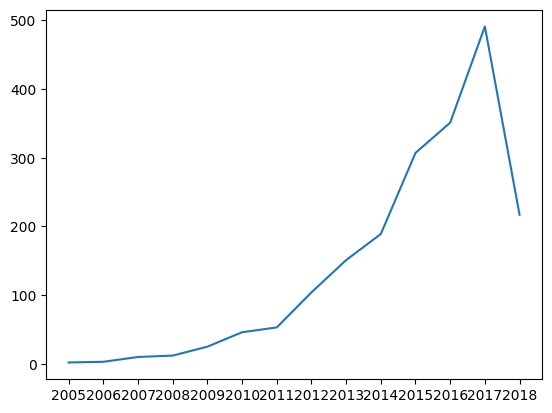

In [17]:
pkgs_years = {}
pkg_name = None
with open('subset_data.csv') as f:
    plines = f.readlines()
    f.close()
i = 0
for pline in plines:
  package_data = pline.split(",")
  pkg_name = package_data[0]
  year = package_data[2][:4]
  if year not in pkgs_years:
    pkgs_years[year] = []
  if package_data[0] not in pkgs_years[year]:
    pkgs_years[year].append(package_data[0])
  i += 1

pkgs_per_year = []
years = sorted(list(pkgs_years.keys()))
for year in years:
  pkgs_per_year.append(len(pkgs_years[year]))
plt.plot(years, pkgs_per_year)

### results data sorter

In [75]:
def yearly_vuln_plot(scan_data):
  # number of vulnerable packages
  vuln_packages_per_year = {}
  # number of vulnerabilities
  vulnerabilities_per_year = {}
  # number of vulnerabilities per severity
  severities_per_year = {}
  # fill packages with list of packages
  severities = ["NULL", "LOW", "MEDIUM", "HIGH", "CRITICAL"]

  for version in scan_data:
    package_name = version['pkg_name']
    if version['num_issues'] > 0:
      year = version["published"]["date"].split("-")[0]
      # add year if not created yet
      if year not in vuln_packages_per_year:
        vuln_packages_per_year[year] = []
        vulnerabilities_per_year[year] = 0
        severities_per_year[year] = {"NULL": 0, "LOW": 0, "MEDIUM": 0, "HIGH": 0, "CRITICAL": 0}
      if package_name not in vuln_packages_per_year[year]:
        vuln_packages_per_year[year].append(package_name)
        vulnerabilities_per_year[year] = vulnerabilities_per_year[year] + int(version['num_issues'])
        for sev in severities:
          severities_per_year[year][sev] = severities_per_year[year][sev] + int(version["issue_severity"][sev])

  vuln_pack_num = []
  null, low, medium, high, critical = [], [], [], [], []
  for year in years:
    if year in vuln_packages_per_year:
      vuln_pack_num.append(len(vuln_packages_per_year[year]))
      null.append(severities_per_year[year]["NULL"])
      low.append(severities_per_year[year]["LOW"])
      medium.append(severities_per_year[year]["MEDIUM"])
      high.append(severities_per_year[year]["HIGH"])
      critical.append(severities_per_year[year]["CRITICAL"])
    else:
      vuln_pack_num.append(0)
      null.append(0)
      low.append(0)
      medium.append(0)
      high.append(0)
      critical.append(0)
  return vuln_pack_num, null, low, medium, high, critical



### import vulnerability scan results


In [76]:
with open('bandit_results.json') as json_data:
    bandit_data = json.load(json_data)
    json_data.close()

bandit_vuln_pkg_num, bandit_null, bandit_low, bandit_medium, bandit_high, bandit_critical = yearly_vuln_plot(bandit_data)
bandit_vuln_pkg_num

[0, 0, 3, 3, 8, 18, 25, 50, 73, 99, 158, 209, 253, 121]

In [77]:
with open('safety_results.json') as json_data:
    safety_data = json.load(json_data)
    json_data.close()
safety_vuln_pkg_num, safety_null, safety_low, safety_medium, safety_high, safety_critical = yearly_vuln_plot(safety_data)
safety_vuln_pkg_num


[1, 0, 0, 0, 0, 3, 1, 3, 4, 2, 1, 2, 5, 5]

## Plots

### Number of vulnerable packages compared to total number of packages

<Figure size 640x480 with 0 Axes>

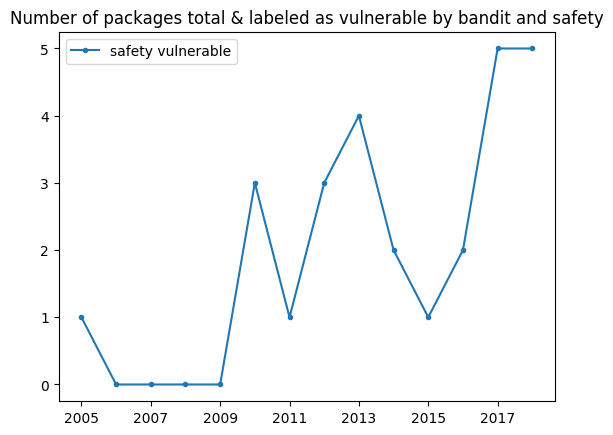

<Figure size 640x480 with 0 Axes>

In [60]:
df = pd.DataFrame({
#'packages': pkgs_per_year,
'safety vulnerable': safety_vuln_pkg_num,
#'bandit4mal vulnerable': bandit_vuln_pkg_num
    }, index=years)
lines = df.plot(style='.-')

plt.title("Number of packages total & labeled as vulnerable by bandit and safety")
plt.legend()
plt.figure()

### Bandit vulnerabilities per year by severity levels

Text(0.5, 1.0, 'Bandit vulnerabilities per year by the severity levels: critical, high, medium, and low.')

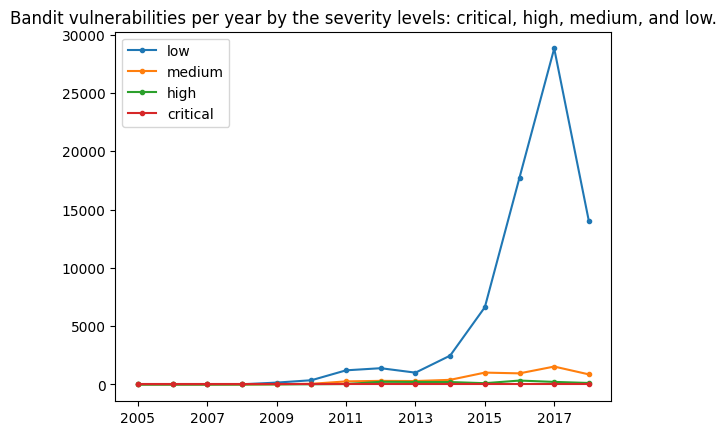

In [69]:
df = pd.DataFrame({
"low": bandit_low,
"medium": bandit_medium,
"high": bandit_high,
"critical": bandit_critical
    }, index=years)
lines = df.plot(style='.-')
plt.title("Bandit vulnerabilities per year by the severity levels: critical, high, medium, and low.")


### Safety vulnerabilities per year by severity levels

Text(0.5, 1.0, 'Safety vulnerabilities per year by the severity levels: critical, high, medium, and low.')

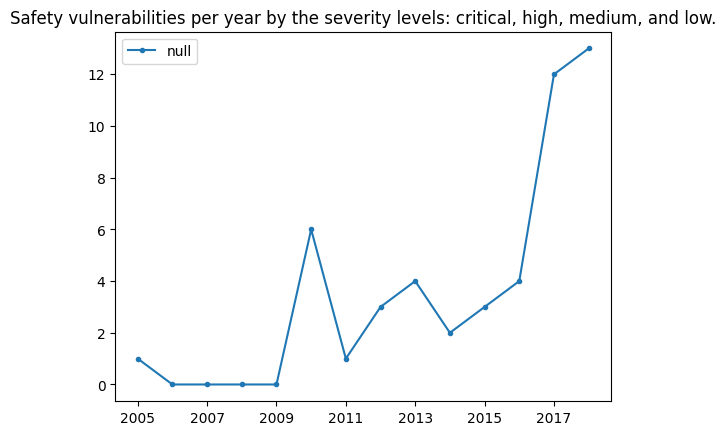

In [68]:
df = pd.DataFrame({
#'bandit4mal vulnerable': bandit_vuln_pkg_num,
'null': safety_null
    }, index=years)
lines = df.plot(style='.-')
plt.title("Safety vulnerabilities per year by the severity levels: critical, high, medium, and low.")


## Generating Kaplan Meier graphs for introduced date - discovery date

In [23]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from datetime import datetime
from decimal import Decimal, ROUND_HALF_UP

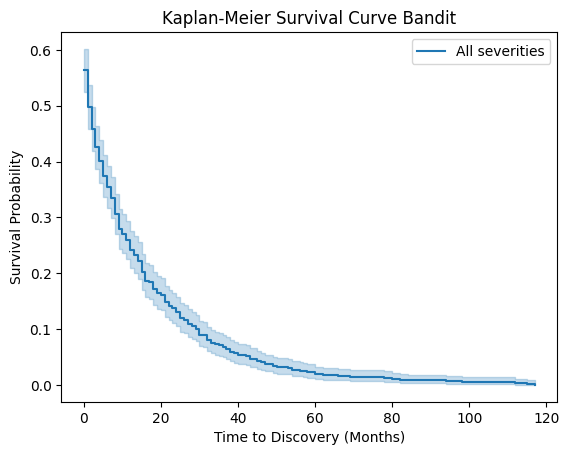

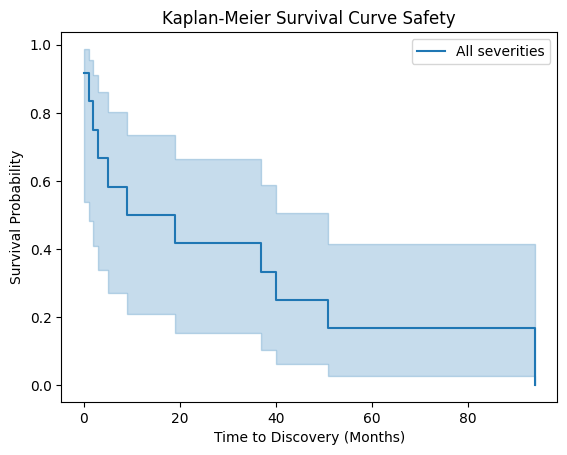

In [39]:
# NOTE: there are some "below comment: seperate severities" comments in this block.
# These comments, if uncommented and bug fixed, could be used for generating a
# Kaplan Meier graph where the severities are seperate lines instead of combined. 
# Due to time constraints and the use of unreliable discovery date interpretation,
# these lines have been commented out.

def vuln_discovery_fix(scan_data, safety):
  severities = ["NULL", "LOW", "MEDIUM", "HIGH", "CRITICAL"]
  i = 0
  all_date_diffs = []
  while i < len(scan_data):
    versions = []
    package_name = scan_data[i]['pkg_name']
    # Get all package versions by adding packages with the same name
    while i < len(scan_data) and scan_data[i]['pkg_name'] == package_name:
      versions.append(scan_data[i])
      i += 1

    # structure of version_diff:
    # [date_introduced, date_discovered, date_introduced, date_discovered, ...]
    version_diff = []
    # below comment: seperate severities
    # issue_version_diff = [[] for _ in range(5)]
    j = 0

    # below comments: seperate severities
    # def get_diff_list(issue_version_diff: list, j: int, sev: int):
    #   k = j
    #   while k < len(versions):
    #     if versions[j]['issue_severity'][severities[sev]] != 0 and versions[j]['published']['date']:
    #       issue_version_diff[sev].append(versions[j]['published']['date'])
    #       while k < len(versions):
    #         if versions[j]['issue_severity'][severities[sev]] == 0 or (j == len(versions) - 1 and versions[j]['published']['date']):
    #           issue_version_diff[sev].append(versions[j]['published']['date'])
    #           k += 1
    #           break
    #         k += 1
    #     k += 1

    while j < len(versions):
      # first check all severities seperate, then check all severities

      # below comments: seperate severities
      # get_diff_list(issue_version_diff, j, 0)
      # get_diff_list(issue_version_diff, j, 1)
      # get_diff_list(issue_version_diff, j, 2)
      # get_diff_list(issue_version_diff, j, 3)
      # get_diff_list(issue_version_diff, j, 4)


      # first version containing issues: date_introduced
      if versions[j]['num_issues'] != 0 and versions[j]['published']['date']:
        version_diff.append(versions[j]['published']['date'])
        while j < len(versions):
          # first version after introduced issues containing no more issues
          # or end of list
          if (versions[j]['num_issues'] == 0 or (j == len(versions) - 1)) and versions[j]['published']['date']:
            version_diff.append(versions[j]['published']['date'])
            j += 1
            # go back to previous while loop to start over
            break
          j += 1
      j += 1
    j = 0
    # the outside while loop always adds zero or two dates per loop
    if len(version_diff) % 2 == 1:
      raise Exception("version_diff should be even length")
    
    # calculate the difference in months and add to list
    while j < len(version_diff):
      diff = datetime.strptime(version_diff[j+1], "%Y-%m-%d") -\
             datetime.strptime(version_diff[j], "%Y-%m-%d")
      all_date_diffs.append(Decimal(diff.days/30.44).quantize(Decimal('0'), rounding=ROUND_HALF_UP))
      j += 2

  # transform from [1, 2, 1, 3, 15, 2, 4, ...]
  # to: discovery_time = [1, 2, 3, 4, 5, 6, 7, ...]
  # and occurences     = [2, 1, 1, 1, 0, 0, 0, ...]
  def generate_graph(date_diffs: list, sev: bool):
    if not sev:
      discovery_time = [j for j in range(0, int(max(date_diffs)) + 1)]
      occurences = [0] * (int(max(date_diffs)) + 1)
      for months in date_diffs:
        occurences[int(months)] += 1

      data = {
        'discovery_time': discovery_time,
        'event_occurrences': occurences
      }

      df = pd.DataFrame(data)

      # Repeat rows based on event_occurrences
      df_expanded = pd.DataFrame(np.repeat(df.values, df['event_occurrences'], axis=0), columns=df.columns)

      # Create a Kaplan-Meier estimator
      kmf = KaplanMeierFitter()

      # Fit the data to the estimator
      kmf.fit(durations=df_expanded['discovery_time'], event_observed=df_expanded['event_occurrences'])

      # Plot the survival curve
      kmf.plot_survival_function(show_censors=True,  label='All severities')

    else:
      for severity, k in enumerate(severities):
        if severity != "NULL":
          print(date_diffs)
          discovery_time = [j for j in range(0, int(max(date_diffs[k])) + 1)]
          occurences = [0] * (int(max(date_diffs[k])) + 1)
          for months in date_diffs[k]:
            occurences[int(months)] += 1

          data = {
            'discovery_time': discovery_time,
            'event_occurrences': occurences
          }

          df = pd.DataFrame(data)

          # Repeat rows based on event_occurrences
          df_expanded = pd.DataFrame(np.repeat(df.values, df['event_occurrences'], axis=0), columns=df.columns)

          # Create a Kaplan-Meier estimator
          kmf = KaplanMeierFitter()

          # Fit the data to the estimator
          kmf.fit(durations=df_expanded['discovery_time'], event_observed=df_expanded['event_occurrences'])



          # Plot the survival curve
          kmf.plot_survival_function(show_censors=True,  label=severity.lower())

    title = "Bandit"
    if safety:
      title = "Safety"
    plt.title('Kaplan-Meier Survival Curve ' + title)
    plt.xlabel('Time to Discovery (Months)')
    plt.ylabel('Survival Probability')
    plt.show()

  generate_graph(all_date_diffs, False)
  # below comment: seperate severities
  # if not safety:
  #   generate_graph(issue_version_diff, True)


vuln_discovery_fix(bandit_data, 0)
vuln_discovery_fix(safety_data, 1)